# Анализ рекламных кампаний мобильного приложения

## Цель проекта

Определить причины, по которым компания-владелец развлекательного приложения Procrastinate Pro+ терпит убытки и дать рекомендации по исправлению ситуации.

## Описание данных

**Сведения представлены в трех csv-таблицах:**

- визиты: `/datasets/visits_info_short.csv`.
- заказы: `/datasets/orders_info_short.csv`.
- расходы: `/datasets/costs_info_short.csv`.

**Структура visits_info_short.csv:**
* User Id — уникальный идентификатор пользователя,
* Region — страна пользователя,
* Device — тип устройства пользователя,
* Channel — идентификатор источника перехода,
* Session Start — дата и время начала сессии,
* Session End — дата и время окончания сессии.

**Структура orders_info_short.csv:**
* User Id — уникальный идентификатор пользователя,
* Event Dt — дата и время покупки,
* Revenue — сумма заказа.

**Структура costs_info_short.csv:**
* dt — дата проведения рекламной кампании,
* Channel — идентификатор рекламного источника,
* costs — расходы на эту кампанию.

## План работы

1) Загрузка данных и их предобработка.

2) Создание функций, необходимых для проведения анализа: функций для расчета основных метрик и построения соответствующих им графиков.

3) Составление профилей пользователей, получение основной информации о способах их привлечения.

4) Маркетинговое исследование: вычисление основных метрик, расходов на рекламу, построение необходимых визуализаций.

5) Исследование окупаемости рекламных кампаний путем анализа графиков.

6) Резюмирование и составление рекомендаций для заказчика исследования.

## Ход выполнения работы

### Загрузка данных и их предобработка

Импортируем все необходимые для работы библиотеки и загрузим данные из представленных датасетов и выведем основную информацию о них:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Пропусков в данных нет, но необходимо также проверить данные на дубликаты:

In [4]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Явных дубликатов не найдено. Теперь необходимо привести типы данных некоторых столбцов к более корректным:

In [5]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

Переименуем названия столбцов для более удобной работы:

In [6]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

### Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии

Создадим функции, необходимые для расчета основных метрик.

Начнем с функции создания профилей, которая будет возвращать датафрейм, состоящий из:
* уникального id юзера;
* источника перехода;
* региона и устройства, с которого пользователь впервые зашел в приложение;
* даты и времени первого использования приложения;
* отдельно - даты первого использования приложения (без указания точного времени);
* отдельно - месяца первого использования приложения;
* поля, указывающего на то, совершал ли пользователь хотя бы одну покупку;
* поля, указывающего, во сколько обошлось привлечение данного пользователя (для органических пользователей значение равно нулю).

Последнее поле найдем путем деления стоимости рекламной кампании на количество пользователей, привлеченных в рамках такой рекламной кампании.

Точные данные по датам позволят разделить пользователей на когорты и провести их дальнейший анализ.

In [7]:
# функция для создания профилей
def get_profiles(visits, orders, costs):
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first',
              'channel': 'first',
              'region': 'first',
              'device': 'first'})
        .reset_index()
        .rename(columns={'session_start': 'first_ts'})
    )
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.month
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # датафрейм для уникальных данных вида:
    # дата - канал привлечения - количество уникальных пользователей 
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .reset_index()
        .rename(columns={'user_id': 'unique_users'})
    )
    
    costs['dt'] = costs['dt'].dt.date
    
    # датафрейм для нахождения стоимости привлечения
    ad_costs = new_users.merge(costs, on=['dt', 'channel'], how='left')
    ad_costs = ad_costs.fillna(0) # заполняем нулями затраты на органических пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on=['dt', 'channel'], how='left')
    
    return profiles

Создадим функцию расчета коэффициента удержания:

In [8]:
# функция для расчета Retention Rate (RR)

def get_retention_rate(profiles, visits, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    # учитываем момент и горизонт анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем ко всем измерениям показатель payer, чтобы отделить платящих пользователей от неплатящих
    dimensions = ['payer'] + dimensions
    
    # создаем датафрейм на основе профилей, дополнив их всеми сессиями пользователей и значением лайфтайма:
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']],
        on='user_id',
        how='left'
    )
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days).fillna(0)
    
    # таблица динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    return result_raw, result_grouped, result_in_time

Создадим функцию нахождения конверсии:

In [9]:
# функция для расчета CR

def get_conversion_rate(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    # учитываем момент и горизонт анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days-1)    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # находим дату и время первой покупки пользователем и добавляем к датафрейму
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .rename(columns={'event_dt': 'first_purchase'})
        .reset_index()
    )
    
    result_raw = result_raw.merge(
        first_purchases,
        on='user_id',
        how='left'
    )
    # добавляем лайфтайм для первой покупки каждого пользователя
    result_raw['lifetime'] = (
        result_raw['first_purchase'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = ['cohort']
    
    # функция группировки по желаемым признакам
    def group_by_dimensions(result_raw, dimensions, horizon_days):
        
        # строим сводную таблицу с количеством покупок
        result_grouped = result_raw.pivot_table(
            index=dimensions,
            columns='lifetime',
            values='user_id',
            aggfunc='nunique'
        )
        
        # считаем сумму с накоплением
        result_grouped = result_grouped.fillna(0)
        result_grouped = result_grouped.cumsum(axis=1)
        
        # заносим сведения о размерах когорт в отдельную таблицу и добавляем в итоговый датафрейм
        cohort_sizes = (
            result_raw.groupby(dimensions)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        result_grouped = cohort_sizes.merge(
            result_grouped,
            on=dimensions,
            how='left'
        ).fillna(0)
    
        # учитываем горизонт анализа
        result_grouped = result_grouped[['cohort_size'] + list(range(horizon_days))]

        # рассчитываем конверсию
        result_grouped = result_grouped.div(
            result_grouped['cohort_size'], axis=0
        ).fillna(0)
        result_grouped['cohort_size'] = cohort_sizes
        
        return result_grouped
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    return result_raw, result_grouped, result_in_time

In [10]:
# функция расчета LTV
def get_ltv(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    # учитываем момент и горизонт анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days-1)    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем сведения о покупках
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left'
    )
    
    # добавляем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions(result_raw, dimensions, horizon_days):
        # строим сводную таблицу со значением выручки, считаем сумму с накоплением
        result_grouped = result_raw.pivot_table(
            index=dimensions,
            columns='lifetime',
            values='revenue',
            aggfunc='sum'
        )

        result_grouped = result_grouped.fillna(0).cumsum(axis=1)

        # заносим сведения о размерах когорт в отдельную таблицу и добавляем в итоговый датафрейм
        cohort_sizes = (
            result_raw.groupby(dimensions)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result_grouped = cohort_sizes.merge(
            result_grouped,
            on=dimensions,
            how='left'
        ).fillna(0)

        # рассчитываем ltv
        result_grouped = result_grouped.div(
            result_grouped['cohort_size'], axis=0
        )
        
        # учитываем горизонт анализа
        result_grouped = result_grouped[['cohort_size'] + list(range(horizon_days))]
        result_grouped['cohort_size'] = cohort_sizes
    
        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = result_raw[['user_id', 'acquisition_cost'] + dimensions].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dimensions)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result_grouped.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result_grouped, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Теперь создадим функции для построения графиков:

In [11]:
# функция сглаживания данных
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [12]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [13]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователя:

In [14]:
profiles = get_profiles(visits, orders, costs)

In [15]:
profiles.head()

,user_id,first_ts,channel,region,device,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,United States,Mac,2019-05-07,5,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,United States,iPhone,2019-07-09,7,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,France,iPhone,2019-10-01,10,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,Germany,PC,2019-08-22,8,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,United States,iPhone,2019-10-02,10,False,0.230769


In [16]:
print('Минимальная дата привлечения пользователя:', min(profiles['first_ts']))
print('Максимальная дата привлечения пользователя:', max(profiles['first_ts']))

Минимальная дата привлечения пользователя: 2019-05-01 00:00:41
Максимальная дата привлечения пользователя: 2019-10-27 23:59:04


Заметим, что даты привлечения пользователей соответствуют заявленным в ТЗ данным.

Определим, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей:

In [17]:
acquisitions_by_region = pd.pivot_table(
    profiles,
    index='region',
    values='user_id',
    aggfunc='nunique'
)

payers_by_region = pd.pivot_table(
    profiles.query('payer == 1'),
    index='region',
    values='user_id',
    aggfunc='count'
)

users_by_region = acquisitions_by_region.merge(
    payers_by_region,
    on='region',
    how='left'
)
users_by_region.columns=['acquisition', 'payer, %']
users_by_region['payer, %'] = users_by_region['payer, %'] / users_by_region['acquisition'] * 100
users_by_region.sort_values(by='acquisition', ascending=False)

,acquisition,"payer, %"
region,,
United States,100002,6.901862
UK,17575,3.982930
France,17450,3.799427
Germany,14981,4.111875


**Наибольшее количество пользователей, в том числе процент платящих - из США.**

Построим аналогичную сводную таблицу касаемо устройств:

In [18]:
acquisitions_by_device = pd.pivot_table(
    profiles,
    index='device',
    values='user_id',
    aggfunc='nunique'
)

payers_by_device = pd.pivot_table(
    profiles.query('payer == 1'),
    index='device',
    values='user_id',
    aggfunc='count'
)

users_by_device = acquisitions_by_device.merge(
    payers_by_device,
    on='device',
    how='left'
)
users_by_device.columns=['acquisition', 'payer, %']
users_by_device['payer, %'] = users_by_device['payer, %'] / users_by_device['acquisition'] * 100
users_by_device.sort_values(by='acquisition', ascending=False)

,acquisition,"payer, %"
device,,
iPhone,54479,6.207897
Android,35032,5.851793
PC,30455,5.046790
Mac,30042,6.364423


**Наибольшее количество привлеченных пользователей на устройствах iPhone, а наибольший процент платящих - с устройствами Mac.**

Также построим сводную таблицу для анализа рекламных источников:

In [19]:
acquisitions_by_channel = pd.pivot_table(
    profiles,
    index='channel',
    values='user_id',
    aggfunc='nunique'
)

payers_by_channel = pd.pivot_table(
    profiles.query('payer == 1'),
    index='channel',
    values='user_id',
    aggfunc='count'
)

users_by_channel = acquisitions_by_channel.merge(
    payers_by_channel,
    on='channel',
    how='left'
)
users_by_channel.columns=['acquisition', 'payer, %']
users_by_channel['payer, %'] = users_by_channel['payer, %'] / users_by_channel['acquisition'] * 100
users_by_channel.sort_values(by='acquisition', ascending=False)

,acquisition,"payer, %"
channel,,
organic,56439,2.055316
FaceBoom,29144,12.204914
TipTop,19561,9.600736
OppleCreativeMedia,8605,2.707728
LeapBob,8553,3.063253
WahooNetBanner,8553,5.296387
RocketSuperAds,4448,7.913669
MediaTornado,4364,3.574702
YRabbit,4312,3.826531


**Наибольшее количество привлеченных пользователей является органическими, однако, доля платящих среди них - наименьшая - всего ~2%. Самой эффективной рекламной кампанией стала Faceboom, которая принесла и наибольшее (после органических) количество привлеченных пользователей, и наивысший процент платящих пользователей среди них - 12.2%.**

### Маркетинговое исследование

Определим расходы на маркетинг:

In [20]:
print('Общая сумма расходов на маркетинг составила', round(sum(costs['costs'])), 'у.е.')

Общая сумма расходов на маркетинг составила 105497 у.е.


Теперь найдем распределение трат по источникам:

In [21]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


**Больше всего денег ушло на TipTop и Faceboom, меньше всего - на MediaTornado и YRabbit.**

Теперь отобразим на графике динамику изменения расходов во времени, для чего добавим к датафрейму `costs` столбцы с указанием номера недели и месяца:

In [22]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

In [23]:
costs

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,43,10
1796,2019-10-24,lambdaMediaAds,6.4,43,10
1797,2019-10-25,lambdaMediaAds,8.8,43,10
1798,2019-10-26,lambdaMediaAds,8.8,43,10


In [24]:
costs_in_week = costs.groupby(['week', 'channel']).agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
costs_in_month = costs.groupby(['month', 'channel']).agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

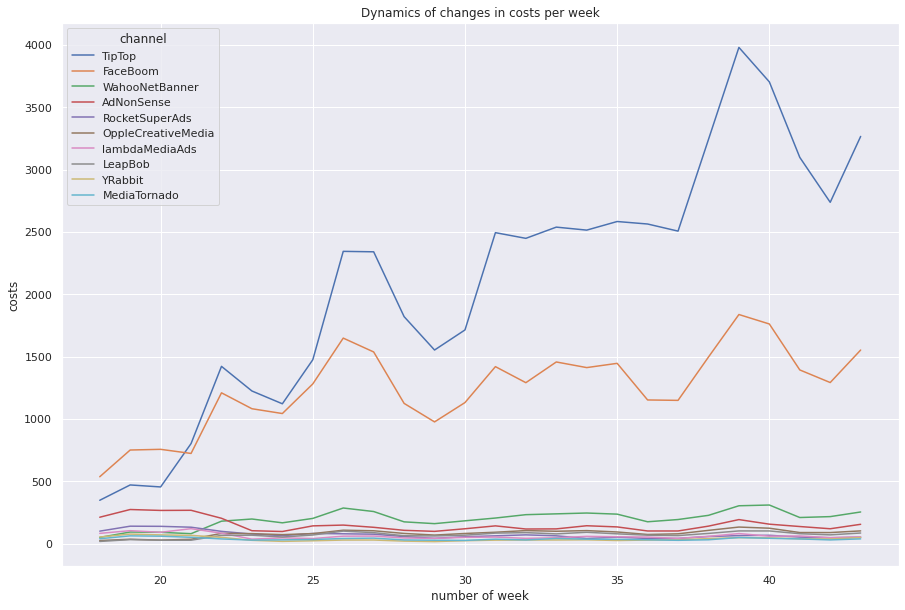

In [25]:
sns.set(rc={'figure.figsize': (15, 10)})
ax = sns.lineplot(data=costs_in_week, x='week', y='costs', hue='channel')
ax.set(xlabel='number of week', ylabel='costs')
plt.title('Dynamics of changes in costs per week');

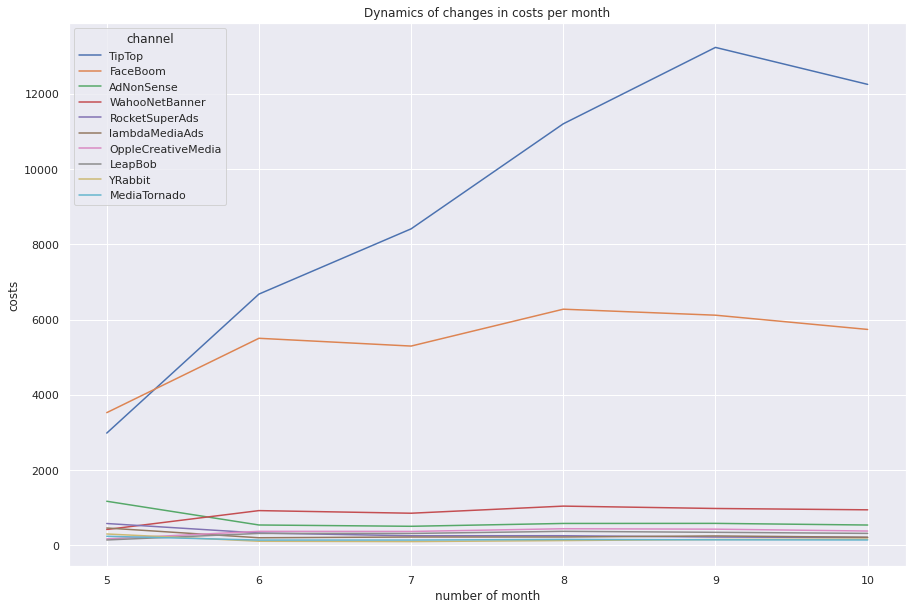

In [26]:
sns.set(rc={'figure.figsize': (15, 10)})
ax = sns.lineplot(data=costs_in_month, x='month', y='costs', hue='channel')
ax.set(xlabel='number of month', ylabel='costs')
plt.title('Dynamics of changes in costs per month');

По графикам можно заметить, что со временем затраты на основные каналы росли: за 5 месяцев расходы на TipTop увеличились на 400%, на FaceBoom - примерно на 50%.

Теперь узнаем, сколько в среднем стоило привлечение пользователя по каждому из источников (CAC):

In [28]:
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False).reset_index()

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


Заметим интересную особенность: **пользователи, привлеченные через каналы TipTop и FaceBoom, на которые выделялось наибольшее количество денежных средств, оказались самыми дорогостоящими. Вероятно, компания терпит убытки как раз из-за невыгодных рекламных вложений.** С другой стороны, именно с этих каналов наибольшее количество платящих пользователей. Данную гипотезу ещё предстоит проверить, поняв, какой доход приносят пользователи с каждой из площадок.

### Оценка окупаемости рекламы

Для начала исключим органических пользователей из анализа, поскольку на них нет никаких рекламных затрат:

In [29]:
profiles = profiles.query('channel != "organic"')

Построим графики для LTV и ROI, а также графики динамики LTV, CAC и ROI для анализа окупаемости рекламы:

In [30]:
observation_date = pd.to_datetime('2019-11-01')
horizon_days = 14

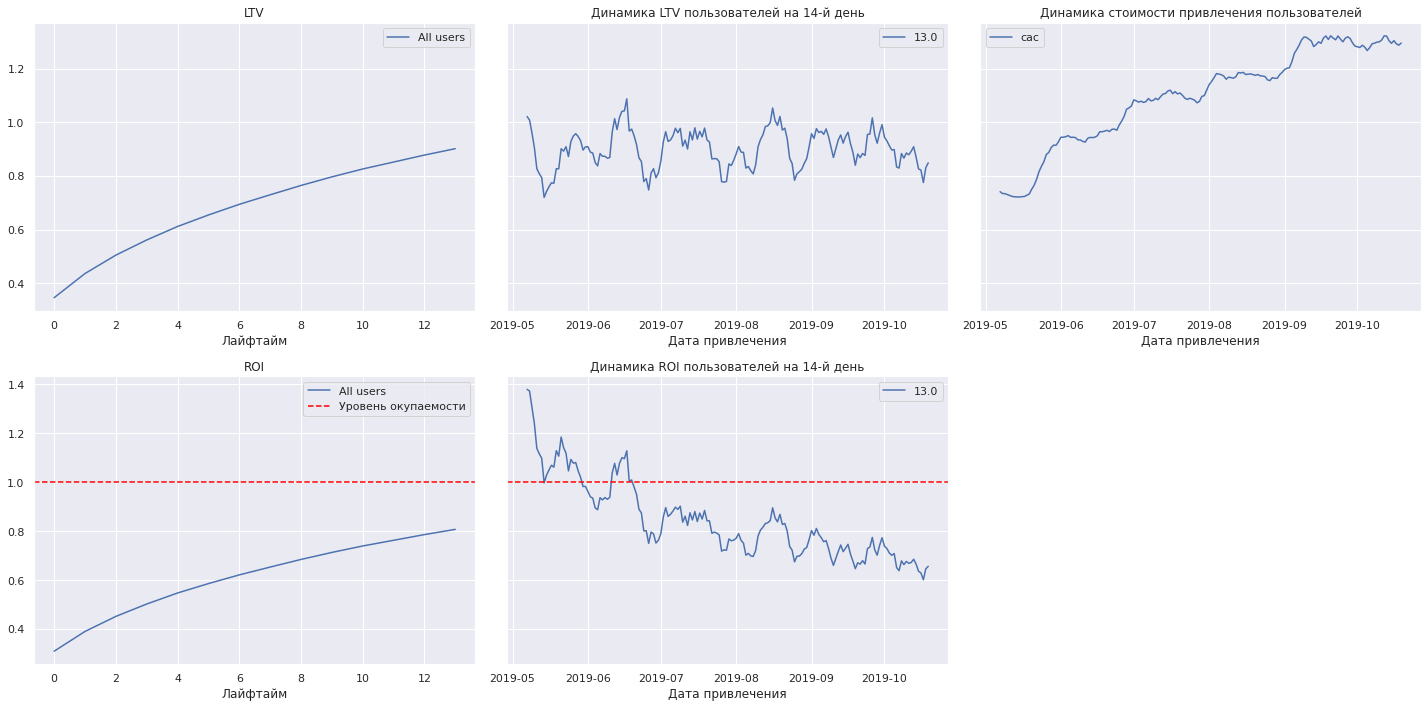

In [31]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

По графикам видно, что динамика ROI пользователей на 14-й день отрицательная: LTV на 14-й день колеблется в рамках одних и тех же значений, а стоимость на привлечение пользователей постоянно растет. С середины июля ROI 14-ого дня начал колебаться в отрицательном диапазоне.
Расходы на рекламу не превышают выручку от привлекаемых клиентов за 2 недели и не окупается: лишь 80% расходов на рекламу возвращается.

Построим и изучим графики удержания и конверсии:

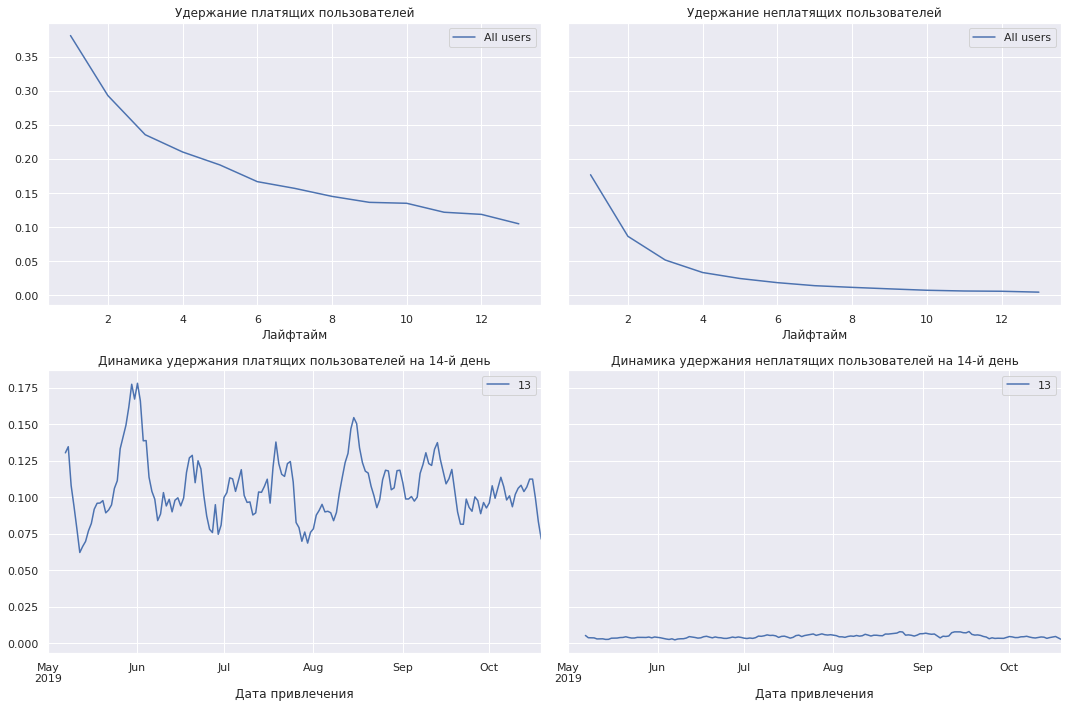

In [32]:
retention_raw, retention, retention_history = get_retention_rate(profiles, visits, observation_date, horizon_days)
plot_retention(retention, retention_history, horizon_days)

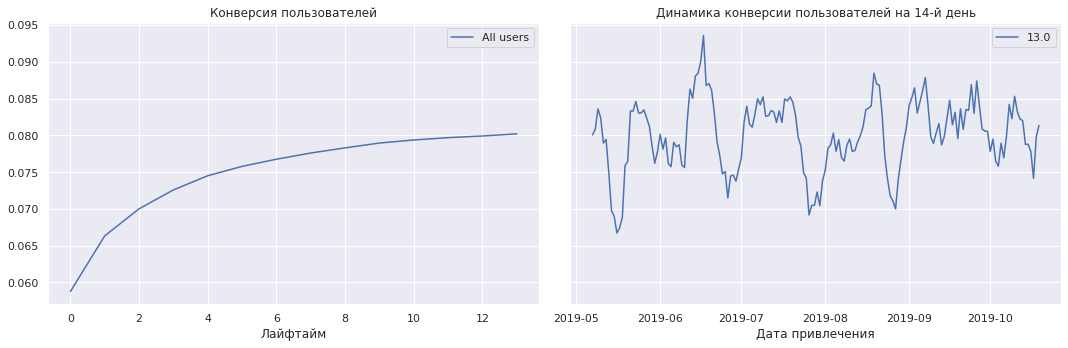

In [33]:
conversion_raw, conversion, conversion_history = get_conversion_rate(profiles, orders, observation_date, horizon_days)
plot_conversion(conversion, conversion_history, horizon_days)

**С увеличением затрат на рекламу в июне, конверсия пользователей на 14-й день также значительно выросла, однако дальнейшее увеличение вложений в рекламу не дало эффекта. В среднем, конверсия пользователей в покупателей к 12 дню составила 8%.**

Динамика удержания платящих пользователей на 14-й день практически не менялась со временем, заметен лишь незначительный отрицательный тренд; удержание неплатящих пользователей на 14-й день крайне низкое: менее 1% возвращались в приложение спустя 2 недели. Видимо, только платная версия приложения обладает для пользователей практическим смыслом.

Исследуем окупаемость рекламы с разбивкой по устройствам:

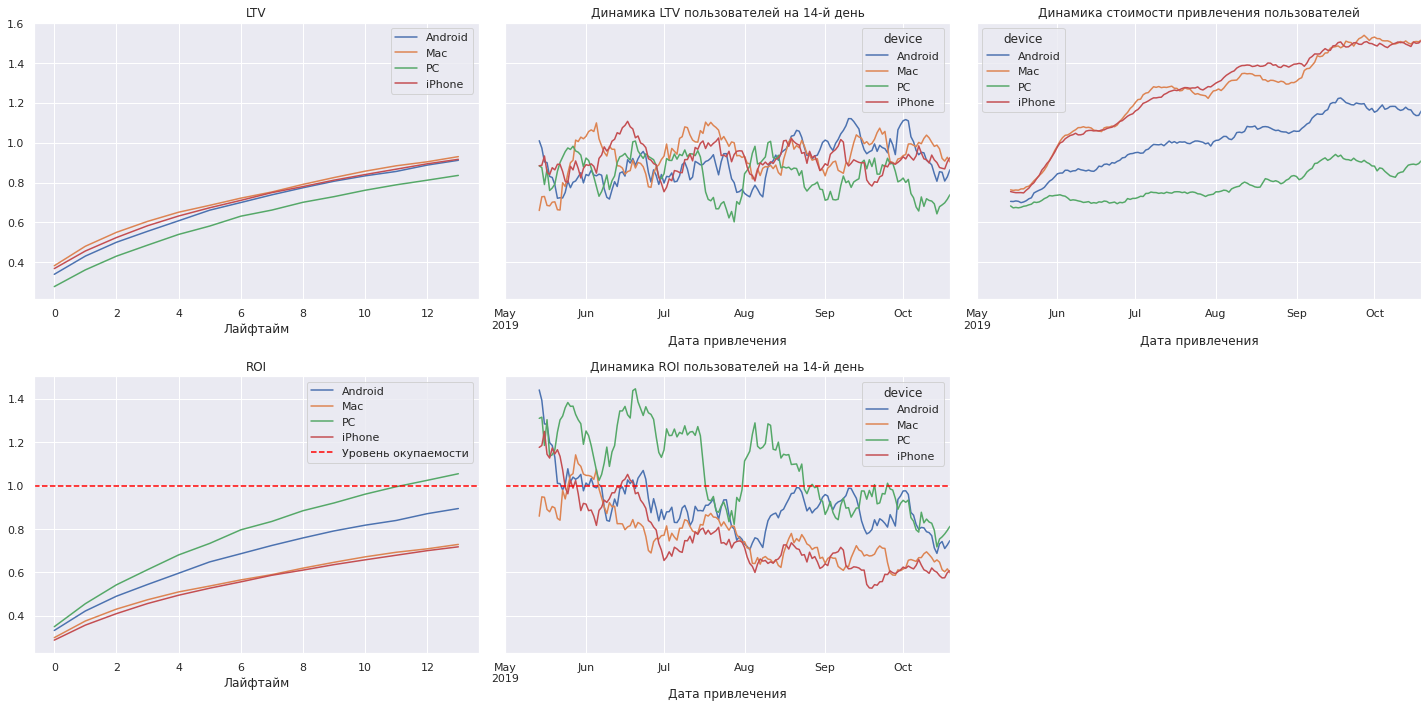

In [34]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)
# указываем window=14 для снижения шума

**На привлечение владельцев продукции Apple уходит намного больше средств, чем на владельцев Android и пользователей PC. Расходы на рекламу окупаются лишь среди пользователей PC, а вот с пользователями Android и, в особенности, iPhone и Mac проблемы - компания терпит убытки от привлечения этих пользователей.**

Теперь исследуем окупаемость рекламы с разбивкой по странам:

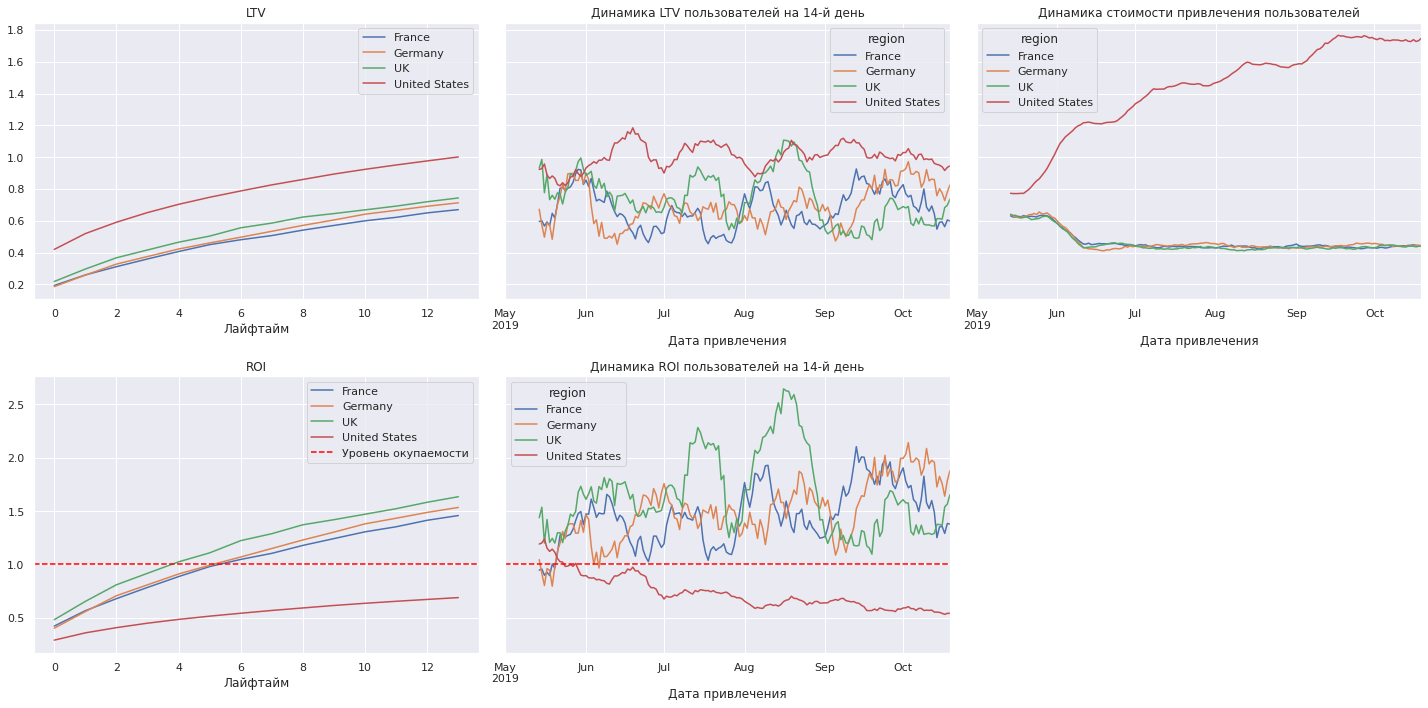

In [35]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

**Расходы на привлечение пользователей в США на порядок превышают стоимость привлечения в других рассматриваемых странах, при этом реклама в этих странах (Германии, Англии и Франции) практически не меняется со временем и хорошо окупается. Вероятно, из-за слишком высокой стоимости рекламы в США клиенты, привлеченные через этот источник, не отбивают расходов даже несмотря на то, что клиенты оттуда приносят в абсолютных значениях больше денег.**

Исследуем окупаемость рекламы с разбивкой по рекламным каналам:

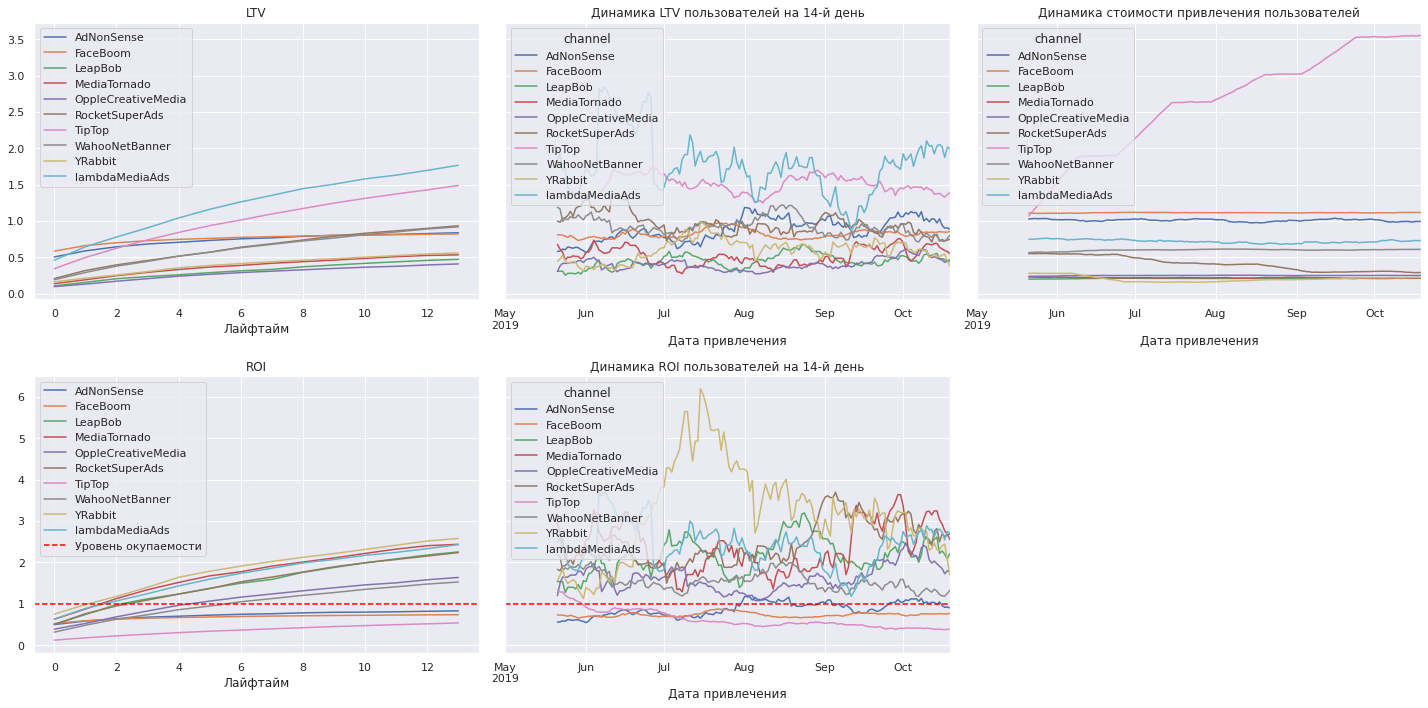

In [36]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=21)

**По графикам видно, что затраты на все источники, кроме TipTop, стабильны: в TipTop же со временем вкладывали всё больше средств. TipTop, AdNonSense и FaceBoom имеют ROI ниже единицы, т.е. не окупаются. Больше всего денег приносят пользователи, пришедшие с lambdaMediaAds и TipTop.**

Построим дополнительно графики удержания и конверсии с разбивкой по стране и устройству:

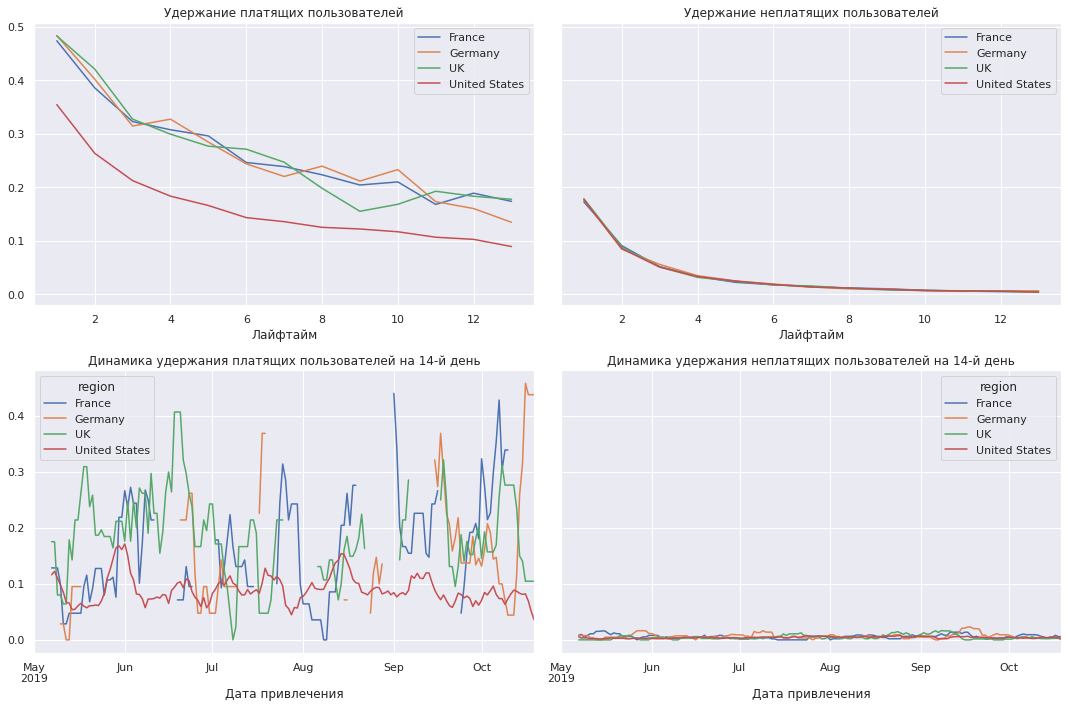

In [37]:
retention_raw, retention, retention_history = get_retention_rate(profiles, visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(retention, retention_history, horizon_days, window=7)

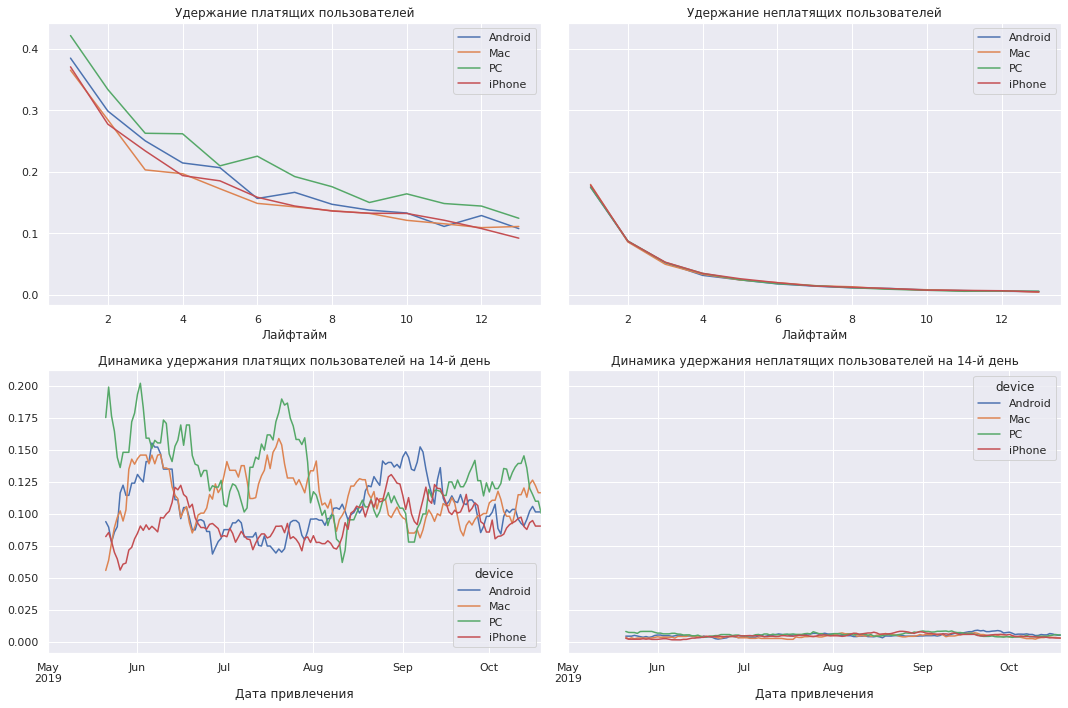

In [38]:
retention_raw, retention, retention_history = get_retention_rate(profiles, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention, retention_history, horizon_days, window=21)

*Здесь и далее на графиках динамики удержания видны пустые места по той причине, что платящие пользователи могли в некоторые моменты вовсе не появляться из определенного источника.*

**По части удержания пользователей, особенностей с разных устройств не замечено (разве что видно, что удержание пользователей PC выше), зато видно сильное отставание платящих пользователей из США.**

Проверим также удержание по каналам:

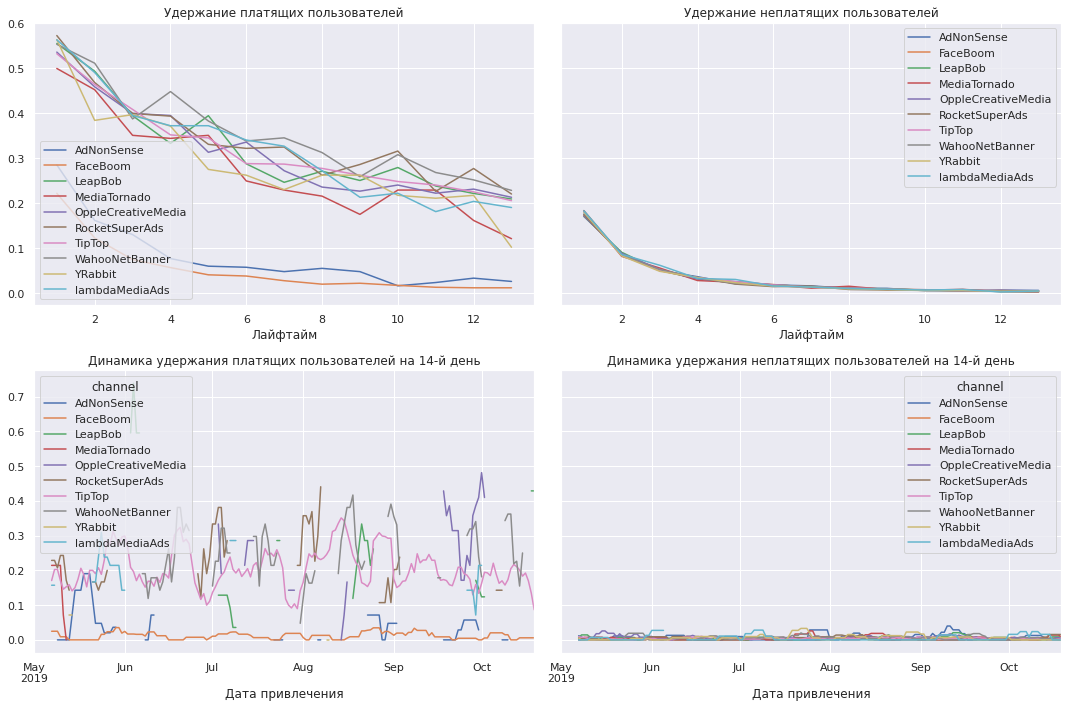

In [39]:
retention_raw, retention, retention_history = get_retention_rate(profiles, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention, retention_history, horizon_days)

**Платящие пользователи, привлеченные с FaceBoom и AdNonSense, удерживаются многократно слабее всех остальных.**

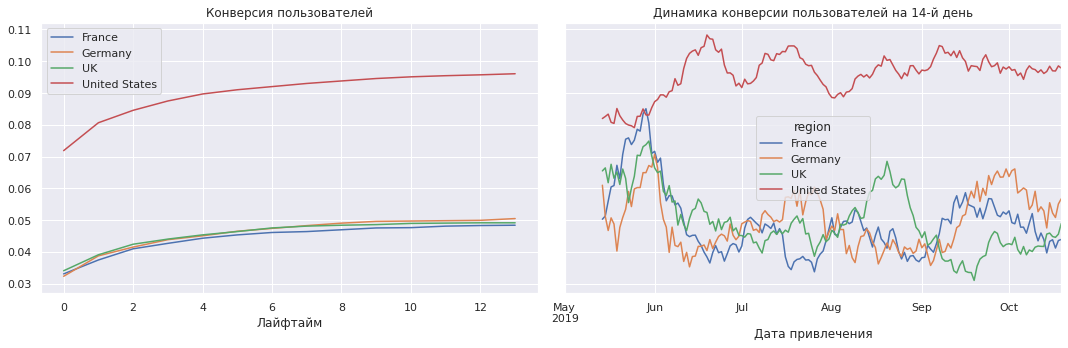

In [40]:
conversion_raw, conversion, conversion_history = get_conversion_rate(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)
plot_conversion(conversion, conversion_history, horizon_days, window=14)

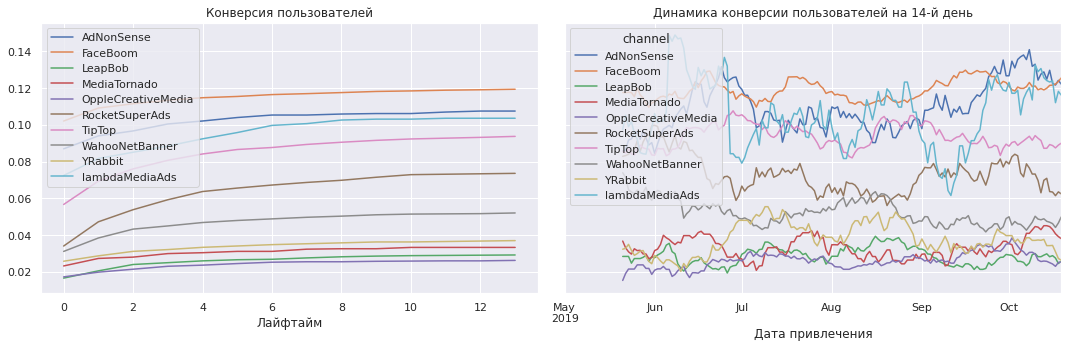

In [41]:
conversion_raw, conversion, conversion_history = get_conversion_rate(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)
plot_conversion(conversion, conversion_history, horizon_days, window=21)

**Заметим, что пользователи, привлекаемые из США и по каналам Faceboom, AdNonSense и lambdaMediaAds обладают довольно высокой конверсией по сравнению с остальными странами и каналами.**

**Резюмируя полученную ранее информацию, можно сделать следующие выводы:**
1. Расходы на рекламу, с учетом поставленного бизнес-плана, не окупаются должным образом: цель достигается лишь на 80%.
2. Владельцы продукции Apple оказывают негативное влияние на окупаемость рекламы, поскольку затраты на их привлечение превышают выручку, которую они приносят. Также негативно сказывается привлечение пользователей из США и через такие рекламные каналы, как TipTop, AdNonSense и FaceBoom.
3. Проблемы окупаемости рекламы могут быть вызваны в результате реализации следующего сценария: маркетологи, заметив, что пользователи, привлеченные из США и использующие устройства Apple приносят больший LTV по сравнению с другими, начали активно вкладывать в рекламу, нацеленную именно на данную группу. Однако, несмотря на бОльшую выручку с данных пользователей, расходы на рекламу оказались столь высокими, что принесли компании больше убытков, чем пользы.

## Итоговые выводы и рекомендации

В ходе проведения работы была выполнена загрузка имеющихся данных и проведена их предобработка. Созданы функции, позволяющие создать профили пользователей, рассчитать основные маркетинговые метрики и построить соответствующие графики.

**В результате анализа метрик были обнаружены следующие особенности, негативно влияющие на финансовое положение компании:**
- на привлечение пользователей Mac и iPhone тратится больше средств, чем такие клиенты в дальнейшем приносят;
- привлечение пользователей из США является самым невыгодным, хотя этот рынок и является самым большим;
- вложения средств в рекламу через каналы TipTop, AdNonSense и FaceBoom неоправданно высокие: реклама с них не окупается.

**На основании полученных данных рекомендуется принять следующие меры по исправлению ситуации:**
1. Снизить расходы на такие каналы, как TipTop, AdNonSense и FaceBoom из-за высокой стоимости за каждого привлеченного пользователя.
2. Применимо к каналу FaceBoom, являющимся лидером по конверсии, стоит рассмотреть альтернативные варианты привлечения пользователей: например, если в ходе рекламной кампании применялись дорогостоящие методы типа CPA или CPI, то стоит перейти, например, на менее дорогой CPC.
2. Поскольку рынок США в рамках предмета исследования является довольно высоко конверсируемым, рекомендуется найти другие рекламные каналы в США, которые были бы менее дорогостоящими.